# SECTION 4 - SENTIMENT ANALYSIS

### PART 1 - CLASSICAL ANALYSIS
Try using VADER from NLTK or HuggingFace transformers. The aim is to classify each comment in the supervised dataset as positive,
negative, or neutral.

a. Note that for sentiment analysis removing some stopwords (e.g., “not”, “never”, “no”) may
be harmful. Slightly adjust your preprocessing pipeline if you deem it useful.

b. What is the overall sentiment distribution across all comments?

c. Visualize sentiment distribution per subreddit using bar charts or heatmaps.

d. Does sentiment correlate with gender?

## 0. Setup and Data

In [30]:
# Install required packages
!pip install pandas numpy matplotlib seaborn nltk scipy

In [31]:
import pandas as pd
import numpy as np
import matplotlib. pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment. vader import SentimentIntensityAnalyzer
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Download VADER lexicon
nltk.download('vader_lexicon')
# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\rocca\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [32]:
# Load the supervised dataset
# For sentiment analysis, we need the original text with stopwords intact

df_supervised = pd.read_csv('../data/data_supervised.csv')
df_target = pd.read_csv('../data/target_supervised.csv')

print(f"Supervised dataset shape: {df_supervised. shape}")
print(f"Target dataset shape: {df_target.shape}")
print(f"\nColumns in supervised data: {df_supervised.columns.tolist()}")
print(f"Columns in target data: {df_target.columns.tolist()}")

Supervised dataset shape: (296042, 4)
Target dataset shape: (5000, 2)

Columns in supervised data: ['author', 'subreddit', 'created_utc', 'body']
Columns in target data: ['author', 'gender']


In [33]:
# Preview the data
print("Sample comments:")
df_supervised.head()

Sample comments:


,author,subreddit,created_utc,body
0,Shamus_Aran,mylittlepony,1.388534e+09,I don't think we'd get nearly as much fanficti...
1,Riddance,sex,1.388534e+09,"Thanks. I made it up, that's how I got over my..."
2,Secret_Wizard,DragonsDogma,1.388534e+09,Are you sure you aren't confusing Cyclops (the...
3,Penultimatum,malefashionadvice,1.388534e+09,dont do this to me bro
4,7-SE7EN-7,todayilearned,1.388534e+09,That's what we do when we can't find a mate


## 1. PREPROCESSING
Remember that is important to NOT remove negation words like "not", "never", "no" as they change the sentiment of a sentence.

Thus we apply minimal preprocessing that preserves sentiment-bearing words.

### NOTE
IT IS VERY IMPORTANT TO REMOVE NON-ENGLISH LANGUAGES SINCE VADER CAN'T REALLY WORK. VADER only works on English, meaningless results on other languages. Must remove non-English for accurate sentiment scores.


In [34]:
# =============================================================================
# LANGUAGE FILTERING - Remove non-English comments before vectorization
# =============================================================================
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
from tqdm import tqdm

# Deterministic results
DetectorFactory.seed = 0

def detect_lang_safe(text:  str) -> str:
    """Safely detect language, handling edge cases"""
    try:
        if not isinstance(text, str) or len(text. strip()) < 3:
            return "short_text"  # Keep short text (assumed English)
        return detect(text)
    except LangDetectException:
        return "short_text"

# Check if language column already exists, otherwise detect
if 'lang' not in df_supervised.columns:
    print("Detecting languages in supervised dataset...")
    tqdm.pandas(desc="Language detection")
    df_supervised['lang'] = df_supervised['body'].fillna('').astype(str).str.strip().progress_apply(detect_lang_safe)

    # Show distribution
    print("\nLanguage distribution:")
    print(df_supervised['lang'].value_counts().head(15))

# Filter:  keep only English + short_text (assumed English)
print(f"\nBefore filtering: {len(df_supervised)} comments")
df_supervised_en = df_supervised[df_supervised['lang']. isin(['en', 'short_text'])].copy()

# Stats
n_removed = len(df_supervised) - len(df_supervised_en)
pct_kept = len(df_supervised_en) / len(df_supervised) * 100
print(f"After filtering (English only): {len(df_supervised_en)} comments")
print(f"Removed: {n_removed} non-English comments ({100-pct_kept:.1f}%)")

# Overwrite for subsequent processing
df_supervised = df_supervised_en.drop(columns=['lang']).reset_index(drop=True)
print(f"\n'df_supervised' now contains {len(df_supervised)} English comments")

Detecting languages in supervised dataset...


Language detection: 100%|██████████| 296042/296042 [18:29<00:00, 266.90it/s]



Language distribution:
lang
en            269676
de              2177
af              2034
fr              1948
short_text      1761
cy              1711
so              1709
nl              1627
da              1186
tl              1135
no              1124
id              1009
it               911
sv               762
pt               738
Name: count, dtype: int64

Before filtering: 296042 comments
After filtering (English only): 271437 comments
Removed: 24605 non-English comments (8.3%)

'df_supervised' now contains 271437 English comments


In [35]:
import html
import re

def preprocess_for_sentiment(text):
    if pd.isna(text):
        return ""
    text = str(text)
    # Decode HTML entities (e.g., &amp; -> &)
    text = html.unescape(text)
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Remove subreddit and user references (r/...  and u/... )
    text = re.sub(r'r/\w+|u/\w+', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply preprocessing
df_supervised['body_sentiment'] = df_supervised['body'].apply(preprocess_for_sentiment)

print("Preprocessing complete!")
print(f"Empty bodies after preprocessing: {(df_supervised['body_sentiment'] == '').sum()}")

Preprocessing complete!
Empty bodies after preprocessing: 964


In [36]:
# Show comparison between original and preprocessed text
comparison_df = df_supervised[['body', 'body_sentiment']].head(5)
for idx, row in comparison_df.iterrows():
    print(f"--- Comment {idx} ---")
    print(f"Original: {row['body'][:200]}..." if len(str(row['body'])) > 200 else f"Original: {row['body']}")
    print(f"Preprocessed: {row['body_sentiment'][:200]}..." if len(row['body_sentiment']) > 200 else f"Preprocessed:  {row['body_sentiment']}")
    print()

--- Comment 0 ---
Original: I don't think we'd get nearly as much fanfiction and pictures shipping Ban-Ban and Lyro. Just saying.
Preprocessed:  I don't think we'd get nearly as much fanfiction and pictures shipping Ban-Ban and Lyro. Just saying.

--- Comment 1 ---
Original: Thanks. I made it up, that's how I got over my first heart break. 
Preprocessed:  Thanks. I made it up, that's how I got over my first heart break.

--- Comment 2 ---
Original: Are you sure you aren't confusing Cyclops (the easiest boss monster) for Ogres? I'm talking about [these guys](http://i.imgur.com/c3YKPdI.jpg)

Maybe I'm just a bad player... But every time I faced on...
Preprocessed: Are you sure you aren't confusing Cyclops (the easiest boss monster) for Ogres? I'm talking about [these guys]( Maybe I'm just a bad player... But every time I faced one on my first playthrough, all m...

--- Comment 3 ---
Original: That's what we do when we can't find a mate
Preprocessed:  That's what we do when we can't find 

## 3. Sentiment Analysis with VADER

**VADER (Valence Aware Dictionary and sEntiment Reasoner)** is a lexicon and rule-based sentiment analysis tool specifically attuned to sentiments expressed in social media.

VADER returns 4 scores:
- `neg`: Negative sentiment proportion
- `neu`: Neutral sentiment proportion
- `pos`: Positive sentiment proportion
- `compound`: Normalized, weighted composite score (-1 to +1)

Classification thresholds (standard):
- Positive: compound >= 0.05
- Negative: compound <= -0.05
- Neutral: -0.05 < compound < 0.05

In [37]:
from tqdm import tqdm
tqdm.pandas()

# Initialize VADER
sia = SentimentIntensityAnalyzer()

def get_sentiment_scores(text):
    if not text or text == "":
        return {'neg': 0, 'neu': 1, 'pos': 0, 'compound': 0}
    return sia.polarity_scores(text)

def classify_sentiment(compound_score):
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

print("Analyzing sentiment for all comments... ")
sentiment_scores = df_supervised['body_sentiment'].progress_apply(get_sentiment_scores)

# Extract individual scores
df_supervised['sentiment_neg'] = sentiment_scores. apply(lambda x: x['neg'])
df_supervised['sentiment_neu'] = sentiment_scores.apply(lambda x: x['neu'])
df_supervised['sentiment_pos'] = sentiment_scores. apply(lambda x: x['pos'])
df_supervised['sentiment_compound'] = sentiment_scores.apply(lambda x: x['compound'])

# Classify sentiment
df_supervised['sentiment_label'] = df_supervised['sentiment_compound'].apply(classify_sentiment)

print("\nSentiment analysis complete!")

Analyzing sentiment for all comments... 


100%|██████████| 271437/271437 [01:22<00:00, 3306.91it/s]



Sentiment analysis complete!


In [38]:
# Preview results
df_supervised[['body_sentiment', 'sentiment_compound', 'sentiment_label']]. head(10)

,body_sentiment,sentiment_compound,sentiment_label
0,I don't think we'd get nearly as much fanficti...,0.0000,neutral
1,"Thanks. I made it up, that's how I got over my...",0.4404,positive
2,Are you sure you aren't confusing Cyclops (the...,-0.4804,negative
3,That's what we do when we can't find a mate,0.0000,neutral
4,Damn I love this question. Here's what I think...,0.9060,positive
5,Sorry about that one post btw lol. I hope it d...,0.0858,positive
6,Ad 1 & 2. Right. I was mistaken. Ad 3. I'm not...,-0.6597,negative
7,I thought it was Colm Meaney whenever he's in ...,-0.0772,negative
8,I hate to respond to such an unnecessarily vul...,0.9760,positive
9,Double minor for sure with all that blood. FACK!,0.3802,positive


## 4. Sentiment Distribution (Task 1b)

In [39]:
# Calculate sentiment distribution
sentiment_counts = df_supervised['sentiment_label'].value_counts()
sentiment_percentages = df_supervised['sentiment_label'].value_counts(normalize=True) * 100

print("Overall Sentiment Distribution:")
print("=" * 40)
for label in ['positive', 'neutral', 'negative']:
    count = sentiment_counts. get(label, 0)
    pct = sentiment_percentages.get(label, 0)
    print(f"{label. capitalize():10s}:  {count:>7,} comments ({pct:.2f}%)")
print(f"{'Total':10s}: {len(df_supervised):>7,} comments")

Overall Sentiment Distribution:
Positive  :  129,783 comments (47.81%)
Neutral   :   68,610 comments (25.28%)
Negative  :   73,044 comments (26.91%)
Total     : 271,437 comments


In [40]:
# Compound score statistics
print("\nCompound Score Statistics:")
print(df_supervised['sentiment_compound'].describe())


Compound Score Statistics:
count    271437.000000
mean          0.136477
std           0.499519
min          -0.999800
25%          -0.128000
50%           0.000000
75%           0.549900
max           0.999800
Name: sentiment_compound, dtype: float64


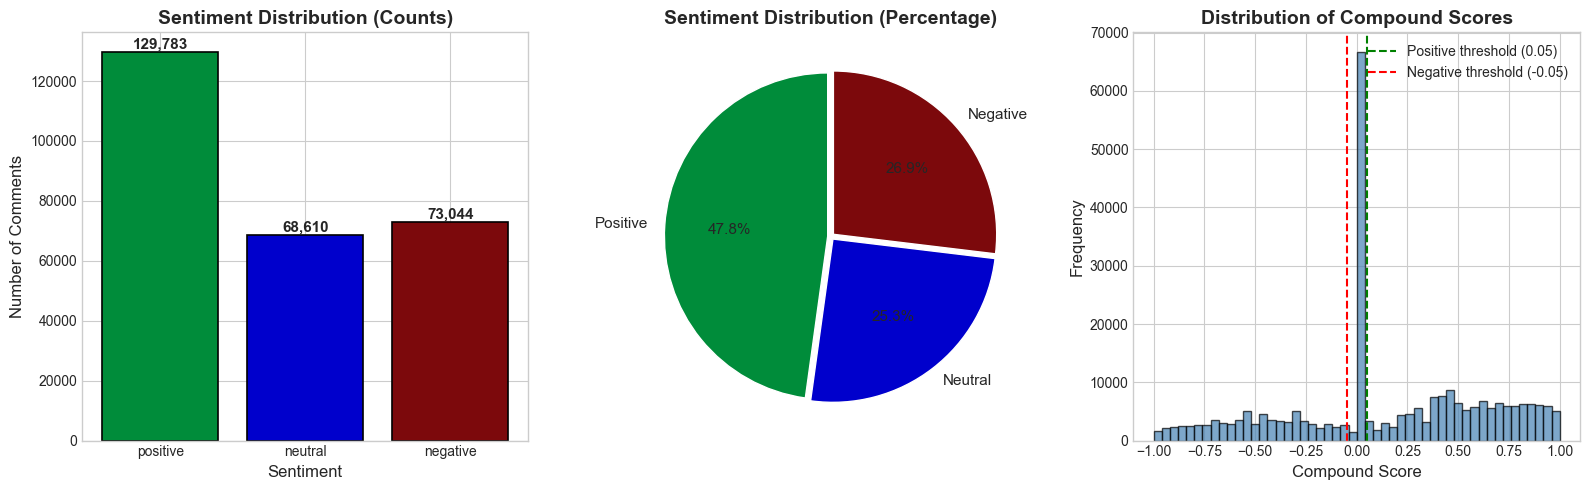


Compound Score Statistics:
count    271437.000000
mean          0.136477
std           0.499519
min          -0.999800
25%          -0.128000
50%           0.000000
75%           0.549900
max           0.999800
Name: sentiment_compound, dtype: float64


In [41]:
# Visualize sentiment distribution
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Bar chart of sentiment counts
colors = {'positive': '#008C3A', 'neutral': '#0000CC', 'negative':  '#7C090C'}
order = ['positive', 'neutral', 'negative']

ax1 = axes[0]
bars = ax1.bar(order, [sentiment_counts. get(s, 0) for s in order],
               color=[colors[s] for s in order], edgecolor='black', linewidth=1.2)
ax1.set_xlabel('Sentiment', fontsize=12)
ax1.set_ylabel('Number of Comments', fontsize=12)
ax1.set_title('Sentiment Distribution (Counts)', fontsize=14, fontweight='bold')

# Add value labels on bars
for bar, label in zip(bars, order):
    height = bar.get_height()
    ax1.annotate(f'{int(height):,}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# 2. Pie chart
ax2 = axes[1]
sizes = [sentiment_counts.get(s, 0) for s in order]
explode = (0.02, 0.02, 0.02)
ax2.pie(sizes, labels=[s.capitalize() for s in order], autopct='%1.1f%%',
        colors=[colors[s] for s in order], explode=explode,
        startangle=90, textprops={'fontsize': 11})
ax2.set_title('Sentiment Distribution (Percentage)', fontsize=14, fontweight='bold')

# 3. Distribution of compound scores
ax3 = axes[2]
ax3.hist(df_supervised['sentiment_compound'], bins=50, color='steelblue',
         edgecolor='black', alpha=0.7)
ax3.axvline(x=0.05, color='green', linestyle='--', label='Positive threshold (0.05)')
ax3.axvline(x=-0.05, color='red', linestyle='--', label='Negative threshold (-0.05)')
ax3.set_xlabel('Compound Score', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('Distribution of Compound Scores', fontsize=14, fontweight='bold')
ax3.legend(loc='upper right')

plt.tight_layout()
plt.savefig('sentiment_overall_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Statistics on compound scores
print("\nCompound Score Statistics:")
print(df_supervised['sentiment_compound'].describe())

## 6. Sentiment Distribution per Subreddit (Task 1c)

**Question:** Visualize sentiment distribution per subreddit using bar charts or heatmaps.

In [42]:
# Calculate sentiment distribution per subreddit
subreddit_sentiment = df_supervised.groupby(['subreddit', 'sentiment_label']).size().unstack(fill_value=0)

# Calculate percentages
subreddit_sentiment_pct = subreddit_sentiment.div(subreddit_sentiment.sum(axis=1), axis=0) * 100

# Reorder columns if they exist
cols_order = ['positive', 'neutral', 'negative']
cols_present = [c for c in cols_order if c in subreddit_sentiment_pct.columns]
subreddit_sentiment_pct = subreddit_sentiment_pct[cols_present]

# Get top 20 subreddits by comment count
top_subreddits = df_supervised['subreddit'].value_counts().head(20).index.tolist()

print(f"Total unique subreddits: {df_supervised['subreddit'].nunique()}")
print(f"\nTop 20 subreddits by comment count:")
print(df_supervised['subreddit'].value_counts().head(20))


Total unique subreddits: 3429

Top 20 subreddits by comment count:
subreddit
AskReddit          28091
ExploreFiction     12436
AskWomen            7981
AskMen              7352
AdviceAnimals       6366
funny               5609
nfl                 5058
pics                4476
RatedRFiction       3609
nba                 3389
WTF                 3193
todayilearned       2890
CFB                 2789
MakeupAddiction     2770
gaming              2513
videos              2483
IAmA                2173
hockey              2079
TumblrInAction      1908
worldnews           1815
Name: count, dtype: int64


In [43]:
# Average compound score per subreddit
subreddit_compound = df_supervised.groupby('subreddit')['sentiment_compound'].agg(['mean', 'std', 'count'])
subreddit_compound = subreddit_compound.sort_values('mean', ascending=False)

# Filter subreddits with at least 100 comments for reliability
subreddit_compound_filtered = subreddit_compound[subreddit_compound['count'] >= 100]

print("\nMost POSITIVE Subreddits (min 100 comments):")
print(subreddit_compound_filtered.head(10))

print("\nMost NEGATIVE Subreddits (min 100 comments):")
print(subreddit_compound_filtered.tail(10))



Most POSITIVE Subreddits (min 100 comments):
                        mean       std  count
subreddit                                    
RandomActsofMakeup  0.596866  0.424075    929
weddingplanning     0.558704  0.450385    148
Indiemakeupandmore  0.541557  0.433517    480
LongDistance        0.511269  0.497091    136
FancyFollicles      0.474379  0.467025    157
amiugly             0.451625  0.406979    196
GoneWildPlus        0.450637  0.361973    109
mtgcube             0.449524  0.539253    139
Rateme              0.449381  0.443444    170
wicked_edge         0.429419  0.457751    110

Most NEGATIVE Subreddits (min 100 comments):
                        mean       std  count
subreddit                                    
Libertarian        -0.063403  0.547158    213
conspiratard       -0.069589  0.495987    343
JusticePorn        -0.073224  0.529536    120
conservatives      -0.084634  0.553780    615
badhistory         -0.089896  0.517702    189
rage               -0.114764  0.50

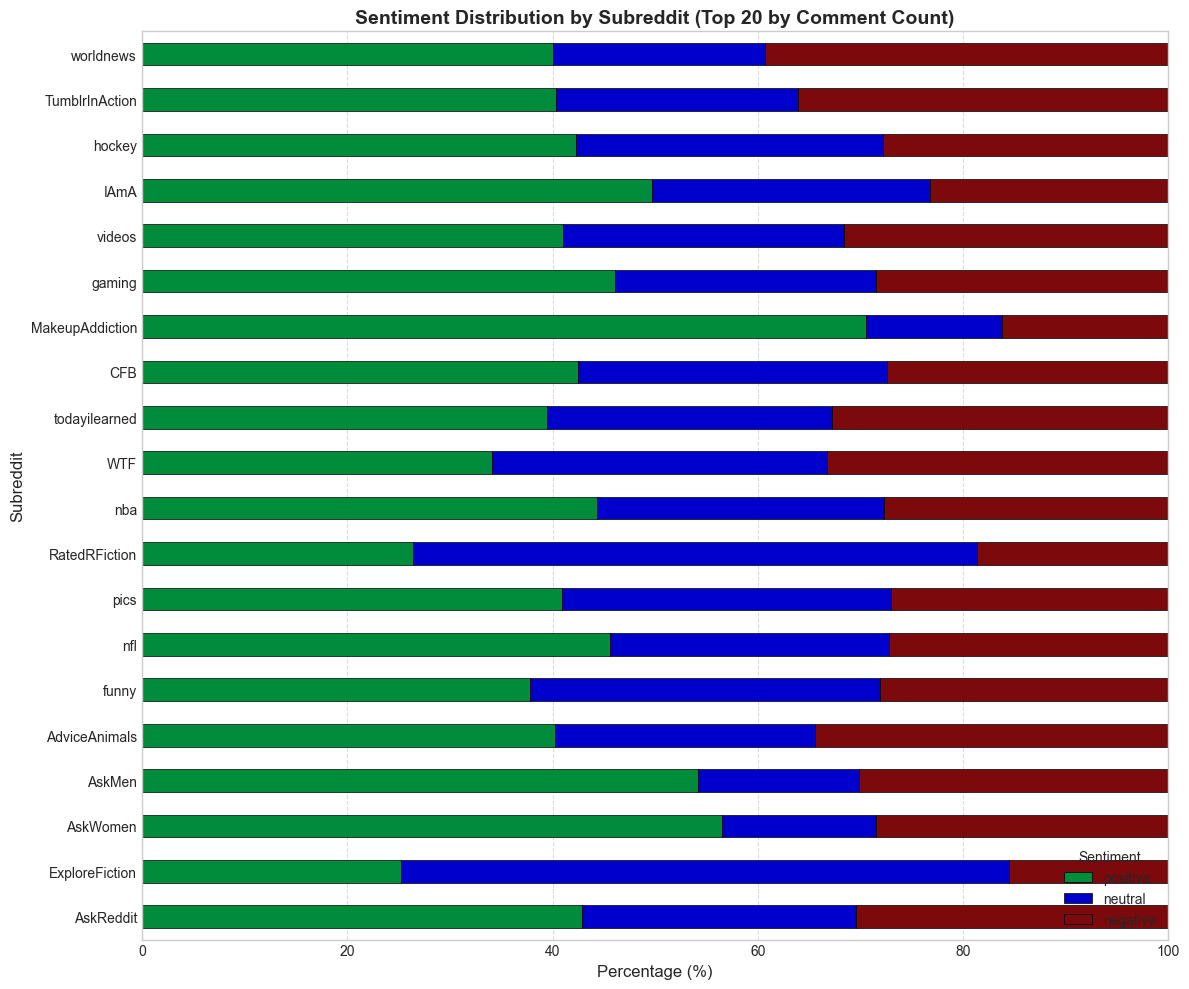

In [44]:
# Stacked horizontal bar chart for top 20 subreddits
fig, ax = plt.subplots(figsize=(12, 10))

# Filter to top subreddits
plot_data = subreddit_sentiment_pct.loc[top_subreddits][cols_present]

# Create stacked bar chart
plot_data.plot(kind='barh', stacked=True, ax=ax,
               color=[colors. get(c, 'gray') for c in cols_present],
               edgecolor='black', linewidth=0.5)

ax.set_xlabel('Percentage (%)', fontsize=12)
ax.set_ylabel('Subreddit', fontsize=12)
ax.set_title('Sentiment Distribution by Subreddit (Top 20 by Comment Count)', fontsize=14, fontweight='bold')
ax.legend(title='Sentiment', loc='lower right', fontsize=10)
ax.set_xlim(0, 100)
ax.xaxis.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('4.2_sentiment_by_subreddit_bar.png', dpi=150, bbox_inches='tight')
plt.show()


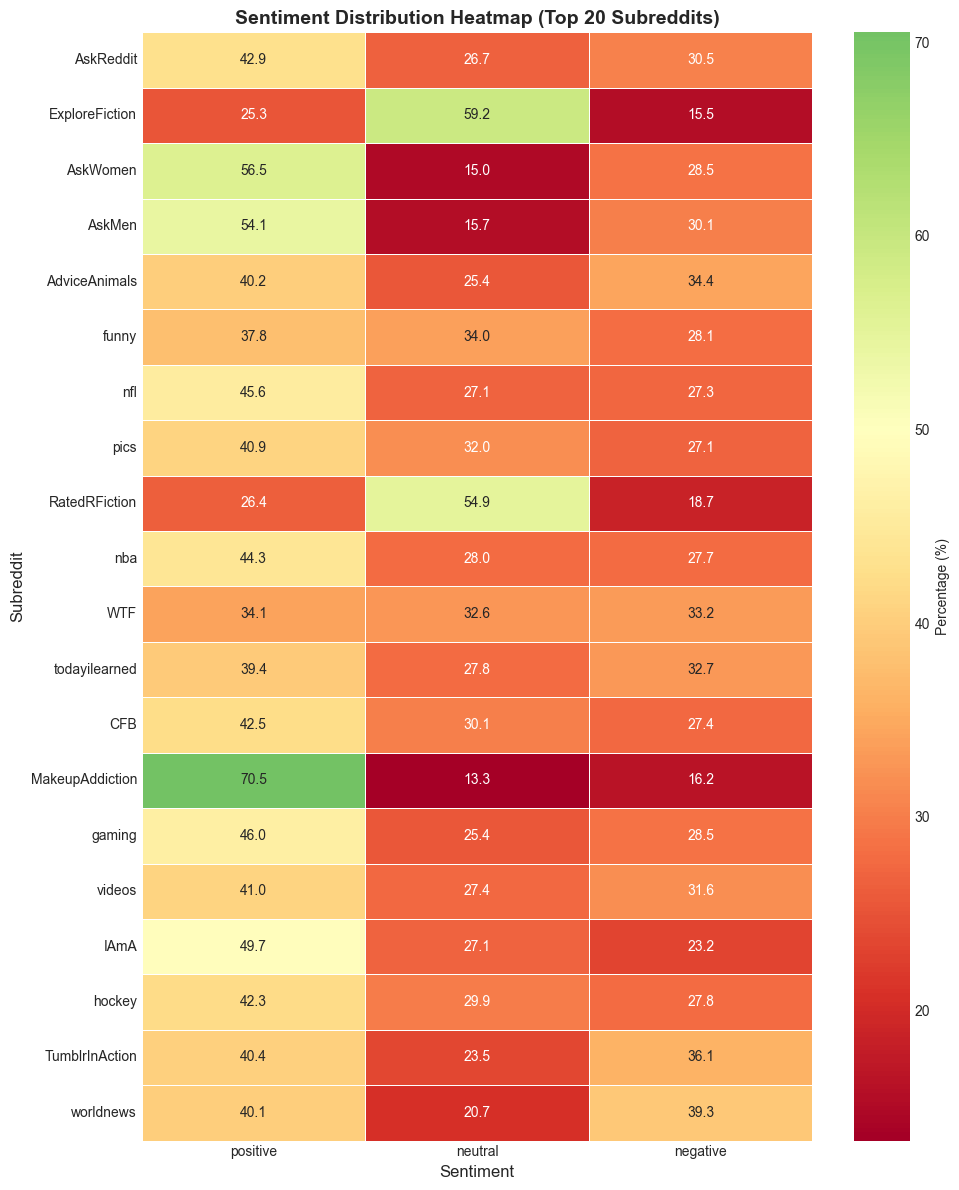

In [45]:
# Heatmap of sentiment distribution
fig, ax = plt.subplots(figsize=(10, 12))

# Prepare heatmap data
heatmap_data = subreddit_sentiment_pct.loc[top_subreddits][cols_present]

# Create heatmap
sns.heatmap(heatmap_data,
            annot=True,
            fmt='.1f',
            cmap='RdYlGn',
            center=50,
            ax=ax,
            linewidths=0.5,
            cbar_kws={'label': 'Percentage (%)'})

ax.set_xlabel('Sentiment', fontsize=12)
ax.set_ylabel('Subreddit', fontsize=12)
ax.set_title('Sentiment Distribution Heatmap (Top 20 Subreddits)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('4.3_sentiment_by_subreddit_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()


### 6.3 Most Positive and Negative Subreddits


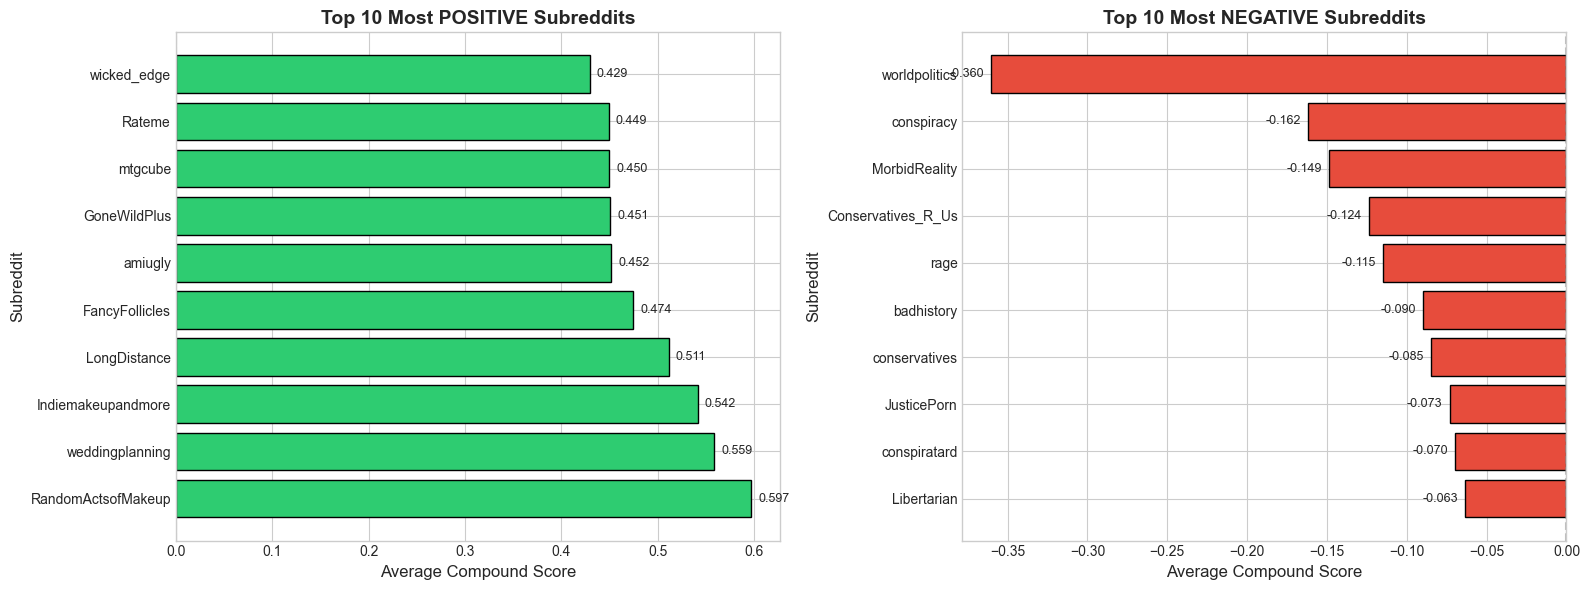

In [46]:
# Bar chart comparing most positive vs most negative subreddits
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 10 most positive subreddits
top_positive = subreddit_compound_filtered.head(10)
ax1 = axes[0]
bars1 = ax1.barh(top_positive. index, top_positive['mean'], color='#2ecc71', edgecolor='black')
ax1.set_xlabel('Average Compound Score', fontsize=12)
ax1.set_ylabel('Subreddit', fontsize=12)
ax1.set_title('Top 10 Most POSITIVE Subreddits', fontsize=14, fontweight='bold')
ax1.axvline(x=0, color='gray', linestyle='--', alpha=0.5)

# Add value labels
for bar in bars1:
    width = bar.get_width()
    ax1.annotate(f'{width:.3f}',
                 xy=(width, bar.get_y() + bar.get_height()/2),
                 ha='left', va='center', fontsize=9, xytext=(5, 0),
                 textcoords='offset points')

# Top 10 most negative subreddits
top_negative = subreddit_compound_filtered.tail(10)
ax2 = axes[1]
bars2 = ax2.barh(top_negative. index, top_negative['mean'], color='#e74c3c', edgecolor='black')
ax2.set_xlabel('Average Compound Score', fontsize=12)
ax2.set_ylabel('Subreddit', fontsize=12)
ax2.set_title('Top 10 Most NEGATIVE Subreddits', fontsize=14, fontweight='bold')
ax2.axvline(x=0, color='gray', linestyle='--', alpha=0.5)

# Add value labels
for bar in bars2:
    width = bar.get_width()
    ax2.annotate(f'{width:.3f}',
                 xy=(width, bar.get_y() + bar.get_height()/2),
                 ha='right' if width < 0 else 'left', va='center', fontsize=9,
                 xytext=(-5 if width < 0 else 5, 0),
                 textcoords='offset points')

plt.tight_layout()
plt.savefig('4.4_sentiment_extreme_subreddits.png', dpi=150, bbox_inches='tight')
plt.show()


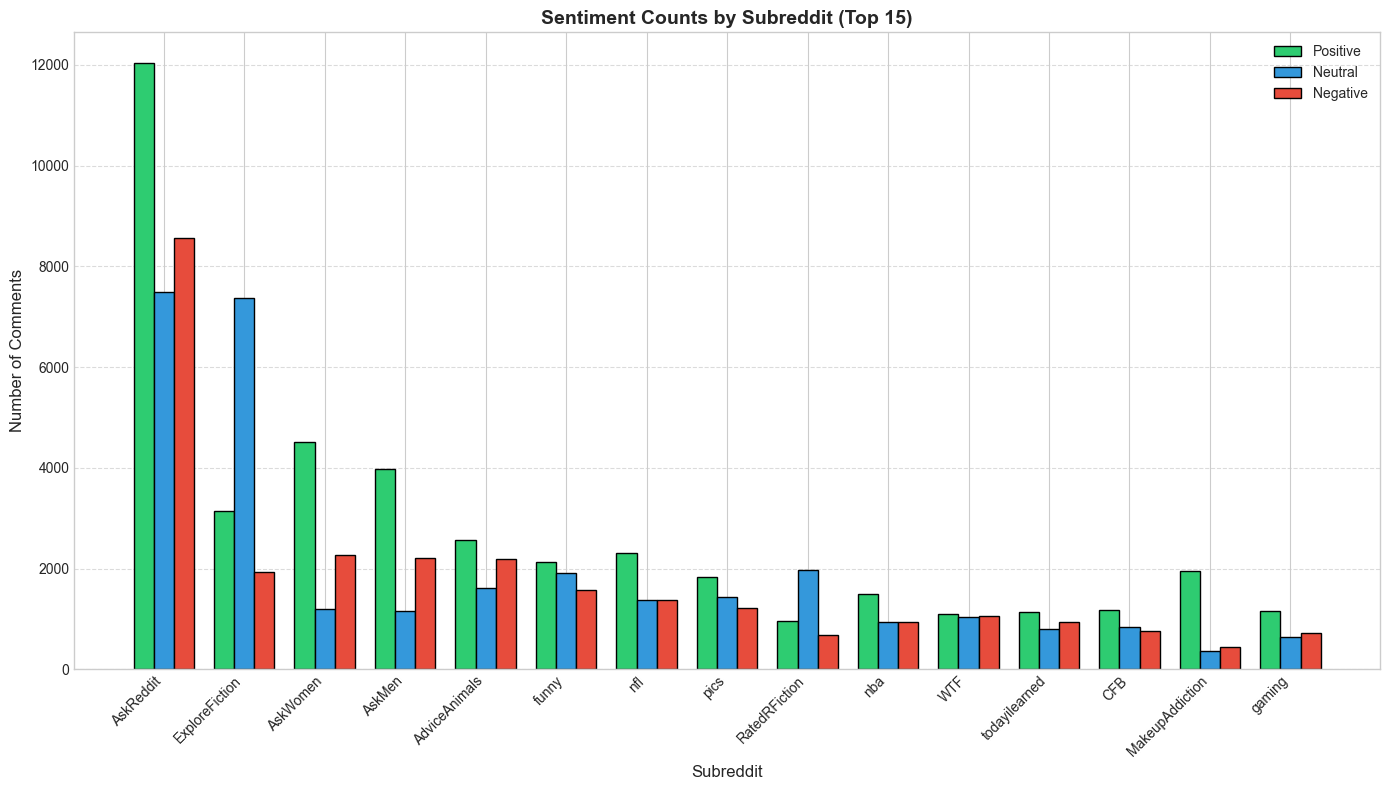

In [47]:
# Grouped bar chart showing actual counts
fig, ax = plt. subplots(figsize=(14, 8))

# Get top 15 subreddits for cleaner visualization
top_15_subs = df_supervised['subreddit'].value_counts().head(15).index.tolist()
plot_counts = subreddit_sentiment. loc[top_15_subs][cols_present]

# Set up bar positions
x = np.arange(len(top_15_subs))
width = 0.25

# Create bars
bars1 = ax.bar(x - width, plot_counts['positive'], width, label='Positive', color='#2ecc71', edgecolor='black')
bars2 = ax.bar(x, plot_counts['neutral'], width, label='Neutral', color='#3498db', edgecolor='black')
bars3 = ax.bar(x + width, plot_counts['negative'], width, label='Negative', color='#e74c3c', edgecolor='black')

ax.set_xlabel('Subreddit', fontsize=12)
ax.set_ylabel('Number of Comments', fontsize=12)
ax.set_title('Sentiment Counts by Subreddit (Top 15)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(top_15_subs, rotation=45, ha='right')
ax.legend()
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('4.5_sentiment_counts_by_subreddit.png', dpi=150, bbox_inches='tight')
plt.show()


## 7. Sentiment Correlation with Gender (Task 1d)

**Question:** Does sentiment correlate with gender?  Do male or female users tend to post
more positive or negative comments?


In [48]:
# Check the structure of the target file
print("Target file structure:")
print(df_target.head())
print(f"\nTarget columns: {df_target.columns.tolist()}")
print(f"Target shape: {df_target.shape}")
# Create author-gender mapping
if 'author' in df_target.columns:
    # If target has author column
    author_gender_map = df_target.set_index('author')['gender'].to_dict()
    print("Using 'author' column from target file for mapping")
else:
    # If target is aligned with unique authors
    unique_authors = df_supervised.drop_duplicates('author')['author'].tolist()

    if len(unique_authors) == len(df_target):
        author_gender_map = dict(zip(unique_authors, df_target['gender']))
        print("Mapping based on author order alignment")
    else:
        # Try sorting alphabetically
        unique_authors_sorted = sorted(df_supervised['author'].unique())
        author_gender_map = dict(zip(unique_authors_sorted, df_target['gender']))
        print("Mapping based on alphabetically sorted authors")

print(f"\nTotal authors mapped: {len(author_gender_map)}")
# Apply gender mapping to dataframe
df_supervised['gender'] = df_supervised['author'].map(author_gender_map)

# Create readable labels (0=Male, 1=Female as per project description)
df_supervised['gender_label'] = df_supervised['gender'].map({0: 'Male', 1: 'Female'})

# Check mapping success
print("Gender Mapping Results:")
print(f"Comments with gender info: {df_supervised['gender'].notna().sum():,}")
print(f"Comments without gender info: {df_supervised['gender'].isna().sum():,}")

print(f"\nGender distribution in comments:")
print(df_supervised['gender_label'].value_counts())
# Calculate sentiment distribution by gender
gender_sentiment = df_supervised.groupby(['gender_label', 'sentiment_label']).size().unstack(fill_value=0)
gender_sentiment_pct = gender_sentiment.div(gender_sentiment.sum(axis=1), axis=0) * 100

print("\nSentiment Distribution by Gender (Counts):")
print(gender_sentiment)

print("\nSentiment Distribution by Gender (Percentages):")
print(gender_sentiment_pct. round(2))


Target file structure:
            author  gender
0     RedThunder90       0
1          Lirkmor       1
2           In0chi       0
3    ProjectGrudge       0
4  TehTurtleHermit       0

Target columns: ['author', 'gender']
Target shape: (5000, 2)
Using 'author' column from target file for mapping

Total authors mapped: 5000
Gender Mapping Results:
Comments with gender info: 271,437
Comments without gender info: 0

Gender distribution in comments:
gender_label
Male      207852
Female     63585
Name: count, dtype: int64

Sentiment Distribution by Gender (Counts):
sentiment_label  negative  neutral  positive
gender_label                                
Female              16974    10889     35722
Male                56070    57721     94061

Sentiment Distribution by Gender (Percentages):
sentiment_label  negative  neutral  positive
gender_label                                
Female              26.69    17.13     56.18
Male                26.98    27.77     45.25


### 7.1 Statistical Analysis - Gender vs Sentiment


In [49]:
# Extract compound scores by gender
male_compound = df_supervised[df_supervised['gender_label'] == 'Male']['sentiment_compound']. dropna()
female_compound = df_supervised[df_supervised['gender_label'] == 'Female']['sentiment_compound'].dropna()

print("=" * 60)
print("STATISTICAL ANALYSIS:  Sentiment by Gender")
print("=" * 60)

print(f"\n--- MALE Users ---")
print(f"  Number of comments: {len(male_compound):,}")
print(f"  Mean compound score: {male_compound. mean():.4f}")
print(f"  Std deviation: {male_compound.std():.4f}")
print(f"  Median:  {male_compound.median():.4f}")
print(f"  Min: {male_compound. min():.4f}")
print(f"  Max: {male_compound.max():.4f}")

print(f"\n--- FEMALE Users ---")
print(f"  Number of comments: {len(female_compound):,}")
print(f"  Mean compound score: {female_compound.mean():.4f}")
print(f"  Std deviation: {female_compound.std():.4f}")
print(f"  Median: {female_compound. median():.4f}")
print(f"  Min: {female_compound.min():.4f}")
print(f"  Max: {female_compound.max():.4f}")

print(f"\n--- DIFFERENCE ---")
mean_diff = female_compound.mean() - male_compound.mean()
print(f"  Difference in means (Female - Male): {mean_diff:.4f}")
if mean_diff > 0:
    print(f"  → Female users are slightly MORE POSITIVE on average")
else:
    print(f"  → Male users are slightly MORE POSITIVE on average")


STATISTICAL ANALYSIS:  Sentiment by Gender

--- MALE Users ---
  Number of comments: 207,852
  Mean compound score: 0.1145
  Std deviation: 0.4829
  Median:  0.0000
  Min: -0.9998
  Max: 0.9997

--- FEMALE Users ---
  Number of comments: 63,585
  Mean compound score: 0.2084
  Std deviation: 0.5442
  Median: 0.2724
  Min: -0.9992
  Max: 0.9998

--- DIFFERENCE ---
  Difference in means (Female - Male): 0.0939
  → Female users are slightly MORE POSITIVE on average


In [50]:
# Statistical Tests

# 1. Mann-Whitney U Test (non-parametric, good for non-normal distributions)
statistic_mw, p_value_mw = stats.mannwhitneyu(male_compound, female_compound, alternative='two-sided')

# 2. Independent t-test (parametric)
statistic_t, p_value_t = stats.ttest_ind(male_compound, female_compound)

# 3. Effect size (Cohen's d)
pooled_std = np.sqrt(((len(male_compound)-1)*male_compound.std()**2 +
                       (len(female_compound)-1)*female_compound.std()**2) /
                      (len(male_compound) + len(female_compound) - 2))
cohens_d = (female_compound.mean() - male_compound.mean()) / pooled_std

print("\n--- STATISTICAL TESTS ---")
print(f"\n1. Mann-Whitney U Test (non-parametric):")
print(f"   Statistic: {statistic_mw: ,.0f}")
print(f"   P-value: {p_value_mw:.6f}")
print(f"   Significant at α=0.05: {'YES' if p_value_mw < 0.05 else 'NO'}")
print(f"   Significant at α=0.01: {'YES' if p_value_mw < 0.01 else 'NO'}")

print(f"\n2. Independent t-test (parametric):")
print(f"   Statistic: {statistic_t:.4f}")
print(f"   P-value: {p_value_t:.6f}")
print(f"   Significant at α=0.05: {'YES' if p_value_t < 0.05 else 'NO'}")

print(f"\n3. Effect Size (Cohen's d): {cohens_d:.4f}")
if abs(cohens_d) < 0.2:
    effect_interpretation = "negligible"
elif abs(cohens_d) < 0.5:
    effect_interpretation = "small"
elif abs(cohens_d) < 0.8:
    effect_interpretation = "medium"
else:
    effect_interpretation = "large"
print(f"   Interpretation: {effect_interpretation} effect")



--- STATISTICAL TESTS ---

1. Mann-Whitney U Test (non-parametric):
   Statistic:  5,823,605,368
   P-value: 0.000000
   Significant at α=0.05: YES
   Significant at α=0.01: YES

2. Independent t-test (parametric):
   Statistic: -41.5949
   P-value: 0.000000
   Significant at α=0.05: YES

3. Effect Size (Cohen's d): 0.1885
   Interpretation: negligible effect


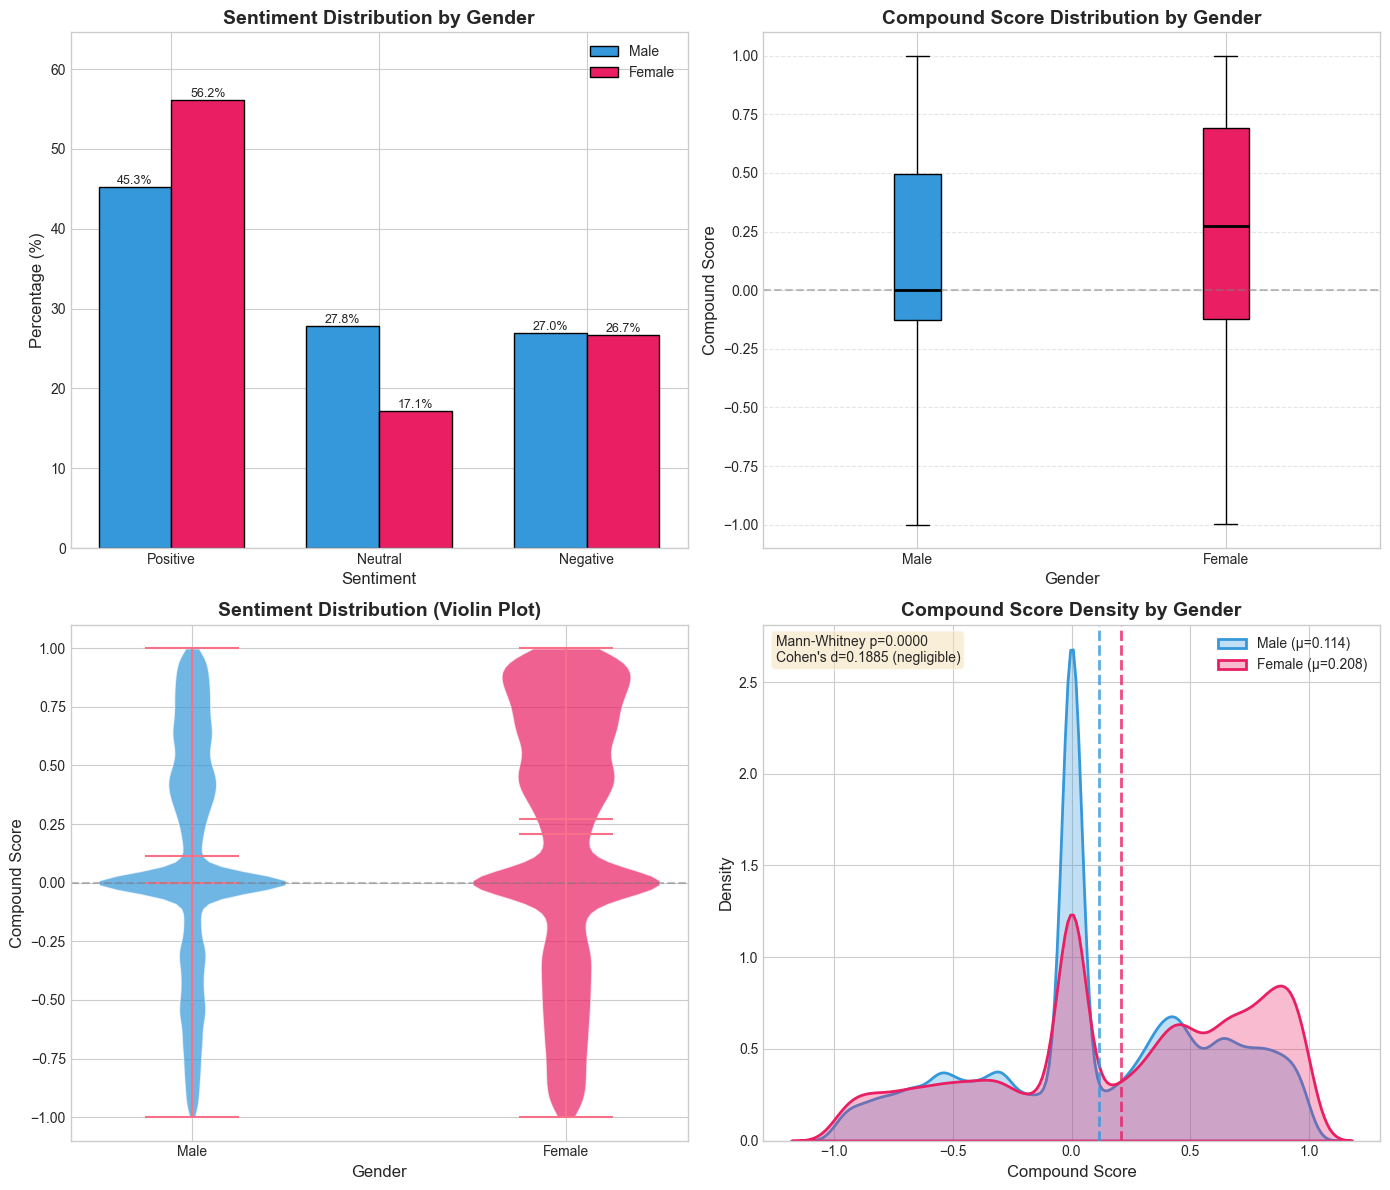

In [51]:
# Comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Grouped Bar Chart - Sentiment percentages by gender
ax1 = axes[0, 0]
x = np.arange(3)
width = 0.35
sentiments = ['positive', 'neutral', 'negative']

male_pct = [gender_sentiment_pct.loc['Male', s] if s in gender_sentiment_pct.columns else 0 for s in sentiments]
female_pct = [gender_sentiment_pct. loc['Female', s] if s in gender_sentiment_pct. columns else 0 for s in sentiments]

bars1 = ax1.bar(x - width/2, male_pct, width, label='Male', color='#3498db', edgecolor='black')
bars2 = ax1.bar(x + width/2, female_pct, width, label='Female', color='#e91e63', edgecolor='black')

ax1.set_xlabel('Sentiment', fontsize=12)
ax1.set_ylabel('Percentage (%)', fontsize=12)
ax1.set_title('Sentiment Distribution by Gender', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels([s.capitalize() for s in sentiments])
ax1.legend()
ax1.set_ylim(0, max(max(male_pct), max(female_pct)) * 1.15)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width()/2, height),
                 ha='center', va='bottom', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    ax1.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width()/2, height),
                 ha='center', va='bottom', fontsize=9)

# 2. Box Plot - Compound score distribution
ax2 = axes[0, 1]
box_data = [male_compound, female_compound]
bp = ax2.boxplot(box_data, labels=['Male', 'Female'], patch_artist=True)

# Color the boxes
bp['boxes'][0].set_facecolor('#3498db')
bp['boxes'][1].set_facecolor('#e91e63')
for median in bp['medians']:
    median.set_color('black')
    median.set_linewidth(2)

ax2.set_xlabel('Gender', fontsize=12)
ax2.set_ylabel('Compound Score', fontsize=12)
ax2.set_title('Compound Score Distribution by Gender', fontsize=14, fontweight='bold')
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax2.yaxis.grid(True, linestyle='--', alpha=0.5)

# 3. Violin Plot - Detailed distribution shape
ax3 = axes[1, 0]
parts = ax3.violinplot([male_compound, female_compound], positions=[1, 2], showmeans=True, showmedians=True)

# Color violins
colors_violin = ['#3498db', '#e91e63']
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors_violin[i])
    pc.set_alpha(0.7)

ax3.set_xticks([1, 2])
ax3.set_xticklabels(['Male', 'Female'])
ax3.set_xlabel('Gender', fontsize=12)
ax3.set_ylabel('Compound Score', fontsize=12)
ax3.set_title('Sentiment Distribution (Violin Plot)', fontsize=14, fontweight='bold')
ax3.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

# 4. KDE Plot - Density comparison
ax4 = axes[1, 1]
sns.kdeplot(data=male_compound, ax=ax4, label=f'Male (μ={male_compound.mean():.3f})',
            color='#3498db', fill=True, alpha=0.3, linewidth=2)
sns.kdeplot(data=female_compound, ax=ax4, label=f'Female (μ={female_compound. mean():.3f})',
            color='#e91e63', fill=True, alpha=0.3, linewidth=2)

# Add mean lines
ax4.axvline(x=male_compound. mean(), color='#3498db', linestyle='--', linewidth=2, alpha=0.8)
ax4.axvline(x=female_compound.mean(), color='#e91e63', linestyle='--', linewidth=2, alpha=0.8)

ax4.set_xlabel('Compound Score', fontsize=12)
ax4.set_ylabel('Density', fontsize=12)
ax4.set_title('Compound Score Density by Gender', fontsize=14, fontweight='bold')
ax4.legend(loc='upper right')

# Add p-value annotation
ax4.text(0.02, 0.98, f'Mann-Whitney p={p_value_mw:.4f}\nCohen\'s d={cohens_d:.4f} ({effect_interpretation})',
         transform=ax4.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('4.6_sentiment_by_gender_analysis.png', dpi=150, bbox_inches='tight')
plt.show()


In [52]:
# Aggregate by user - average sentiment per user
user_sentiment = df_supervised.groupby(['author', 'gender_label']).agg({
    'sentiment_compound': ['mean', 'std', 'count'],
    'sentiment_pos': 'mean',
    'sentiment_neg': 'mean',
    'sentiment_neu': 'mean'
}).reset_index()

# Flatten column names
user_sentiment.columns = ['author', 'gender_label', 'compound_mean', 'compound_std',
                          'num_comments', 'pos_mean', 'neg_mean', 'neu_mean']

print("User-level Sentiment Statistics:")
print(user_sentiment. groupby('gender_label').agg({
    'compound_mean': ['mean', 'std', 'median'],
    'num_comments': ['mean', 'sum']
}).round(4))


User-level Sentiment Statistics:
             compound_mean                 num_comments        
                      mean     std  median         mean     sum
gender_label                                                   
Female              0.2298  0.2830  0.2254      47.7724   63585
Male                0.1601  0.2311  0.1424      57.4653  207852


In [55]:
# User-level statistical test
male_users = user_sentiment[user_sentiment['gender_label'] == 'Male']['compound_mean'].dropna()
female_users = user_sentiment[user_sentiment['gender_label'] == 'Female']['compound_mean']. dropna()

stat_user, p_user = stats.mannwhitneyu(male_users, female_users, alternative='two-sided')

print(f"\n--- USER-LEVEL ANALYSIS ---")
print(f"Male users: n={len(male_users)}, mean={male_users.mean():.4f}")
print(f"Female users:  n={len(female_users)}, mean={female_users.mean():.4f}")
print(f"Mann-Whitney U p-value: {p_user:.6f}")
print(f"Significant at α=0.05: {'YES' if p_user < 0.05 else 'NO'}")



--- USER-LEVEL ANALYSIS ---
Male users: n=3617, mean=0.1601
Female users:  n=1331, mean=0.2298
Mann-Whitney U p-value: 0.000000
Significant at α=0.05: YES


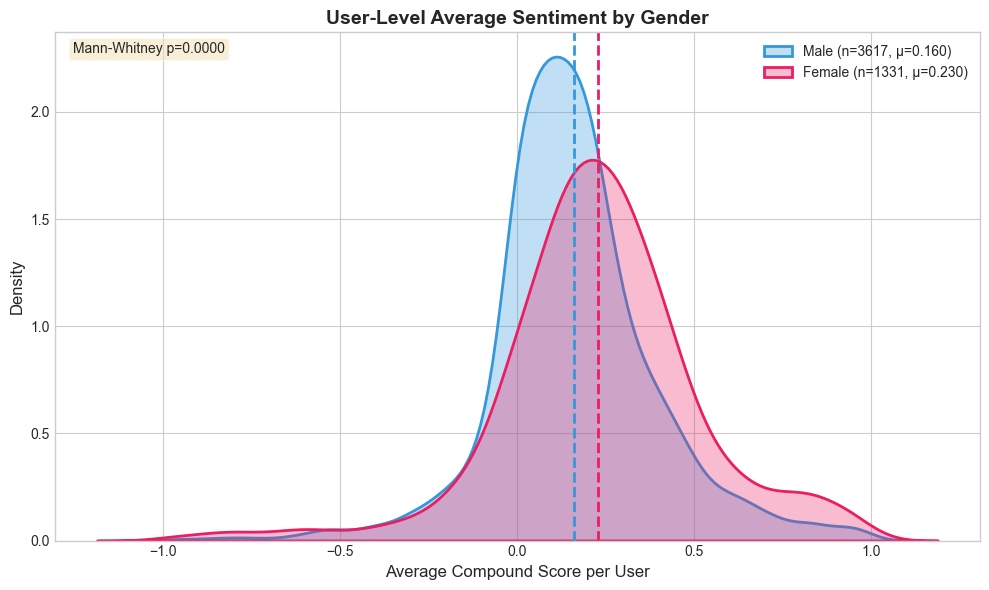

In [56]:
# User-level visualization
fig, ax = plt.subplots(figsize=(10, 6))

sns.kdeplot(data=male_users, ax=ax, label=f'Male (n={len(male_users)}, μ={male_users. mean():.3f})',
            color='#3498db', fill=True, alpha=0.3, linewidth=2)
sns.kdeplot(data=female_users, ax=ax, label=f'Female (n={len(female_users)}, μ={female_users.mean():.3f})',
            color='#e91e63', fill=True, alpha=0.3, linewidth=2)

ax.axvline(x=male_users.mean(), color='#3498db', linestyle='--', linewidth=2)
ax.axvline(x=female_users.mean(), color='#e91e63', linestyle='--', linewidth=2)

ax.set_xlabel('Average Compound Score per User', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('User-Level Average Sentiment by Gender', fontsize=14, fontweight='bold')
ax.legend()

ax.text(0.02, 0.98, f'Mann-Whitney p={p_user:.4f}',
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('4.7_sentiment_by_gender_user_level.png', dpi=150, bbox_inches='tight')
plt.show()


In [57]:
# Analyze if gender differences vary across subreddits
gender_subreddit_sentiment = df_supervised.groupby(['subreddit', 'gender_label'])['sentiment_compound'].mean().unstack()

# Filter to subreddits with enough data from both genders
min_comments_per_gender = 50
gender_counts = df_supervised. groupby(['subreddit', 'gender_label']).size().unstack(fill_value=0)

# Check which columns exist
if 'Male' in gender_counts.columns and 'Female' in gender_counts.columns:
    valid_subreddits = gender_counts[(gender_counts['Male'] >= min_comments_per_gender) &
                                      (gender_counts['Female'] >= min_comments_per_gender)].index

    gender_subreddit_filtered = gender_subreddit_sentiment. loc[valid_subreddits]. copy()
    gender_subreddit_filtered['difference'] = gender_subreddit_filtered['Female'] - gender_subreddit_filtered['Male']
    gender_subreddit_filtered = gender_subreddit_filtered. sort_values('difference')

    print(f"Subreddits with >= {min_comments_per_gender} comments from each gender:  {len(valid_subreddits)}")
    print("\nSubreddits where FEMALES are more positive than males:")
    print(gender_subreddit_filtered[gender_subreddit_filtered['difference'] > 0]. tail(10))
    print("\nSubreddits where MALES are more positive than females:")
    print(gender_subreddit_filtered[gender_subreddit_filtered['difference'] < 0].head(10))
else:
    print("Warning:  Missing gender data in some subreddits")
    gender_subreddit_filtered = None


Subreddits with >= 50 comments from each gender:  116

Subreddits where FEMALES are more positive than males:
gender_label            Female      Male  difference
subreddit                                           
hearthstone           0.268842  0.062476    0.206366
electronic_cigarette  0.389684  0.182609    0.207075
aww                   0.322448  0.114416    0.208033
TalesFromRetail       0.179719 -0.050825    0.230544
chemistry             0.351845  0.117669    0.234176
confession            0.225125 -0.010126    0.235251
Fantasy               0.433704  0.141439    0.292265
Rateme                0.686018  0.350782    0.335236
ffxiv                 0.352421 -0.001500    0.353921
watchpeopledie        0.328649 -0.028641    0.357290

Subreddits where MALES are more positive than females:
gender_label         Female      Male  difference
subreddit                                        
writing            0.051877  0.301870   -0.249993
MakeupAddiction    0.391237  0.557336   -0.16609

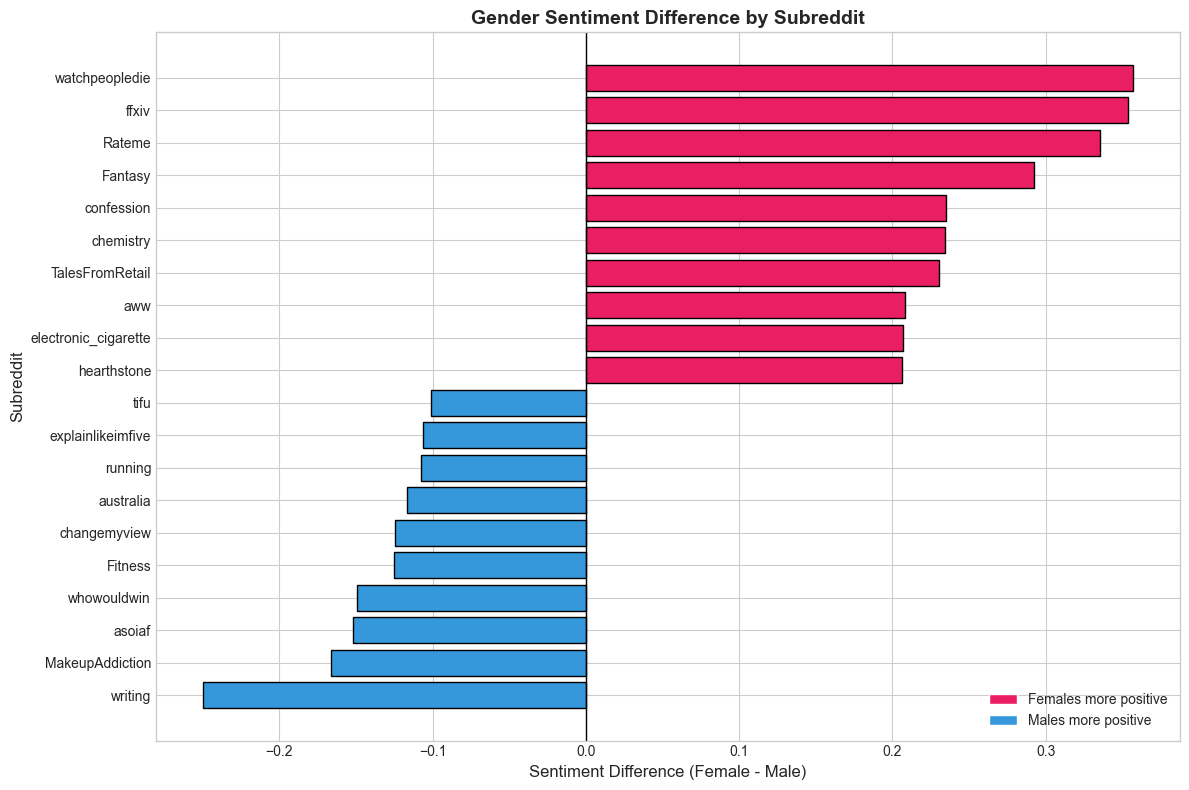

In [58]:
# Visualize gender differences across subreddits
if gender_subreddit_filtered is not None and len(gender_subreddit_filtered) > 0:
    fig, ax = plt.subplots(figsize=(12, 8))

    # Take top 10 from each direction
    n_show = min(10, len(gender_subreddit_filtered) // 2)
    if n_show > 0:
        top_female_positive = gender_subreddit_filtered.tail(n_show)
        top_male_positive = gender_subreddit_filtered.head(n_show)
        plot_df = pd.concat([top_male_positive, top_female_positive])

        colors_diff = ['#e91e63' if x > 0 else '#3498db' for x in plot_df['difference']]
        ax.barh(plot_df. index, plot_df['difference'], color=colors_diff, edgecolor='black')

        ax.axvline(x=0, color='black', linewidth=1)
        ax.set_xlabel('Sentiment Difference (Female - Male)', fontsize=12)
        ax.set_ylabel('Subreddit', fontsize=12)
        ax.set_title('Gender Sentiment Difference by Subreddit', fontsize=14, fontweight='bold')

        # Add legend
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor='#e91e63', label='Females more positive'),
                           Patch(facecolor='#3498db', label='Males more positive')]
        ax.legend(handles=legend_elements, loc='lower right')

        plt.tight_layout()
        plt.savefig('4.8_sentiment_gender_difference_by_subreddit.png', dpi=150, bbox_inches='tight')
        plt.show()
    else:
        print("Not enough data for subreddit-gender interaction plot")
else:
    print("Skipping subreddit-gender interaction plot due to missing data")


In [60]:
print("=" * 70)
print("SECTION 4 - SENTIMENT ANALYSIS:  SUMMARY OF FINDINGS")
print("=" * 70)

print("\n📊 TASK 1a - PREPROCESSING:")
print("-" * 50)
print("• Used MINIMAL preprocessing for sentiment analysis")
print("• PRESERVED negation words (not, never, no) - crucial for sentiment!")
print("• PRESERVED punctuation (!  ?) and case sensitivity")
print("• REMOVED only URLs and Reddit-specific references (r/, u/)")

print("\n📈 TASK 1b - OVERALL SENTIMENT DISTRIBUTION:")
print("-" * 50)
for label in ['positive', 'neutral', 'negative']:
    pct = sentiment_percentages. get(label, 0)
    count = sentiment_counts.get(label, 0)
    print(f"• {label. capitalize():10s}:  {count:>7,} comments ({pct: >5.1f}%)")

print("\n🗂️ TASK 1c - SENTIMENT PER SUBREDDIT:")
print("-" * 50)
print(f"• Analyzed {df_supervised['subreddit'].nunique()} unique subreddits")
print(f"• Most positive subreddit: {subreddit_compound_filtered.index[0]} (mean={subreddit_compound_filtered. iloc[0]['mean']:.3f})")
print(f"• Most negative subreddit: {subreddit_compound_filtered.index[-1]} (mean={subreddit_compound_filtered.iloc[-1]['mean']:.3f})")
print("• Visualizations:  stacked bar chart, heatmap, extreme subreddits comparison")

print("\n👫 TASK 1d - SENTIMENT vs GENDER:")
print("-" * 50)
print(f"• Male comments: n={len(male_compound):,}, mean={male_compound. mean():.4f}")
print(f"• Female comments: n={len(female_compound):,}, mean={female_compound.mean():.4f}")
print(f"• Difference (Female - Male): {mean_diff: .4f}")

if mean_diff > 0:
    print("• Finding:  Female users post SLIGHTLY MORE POSITIVE comments")
else:
    print("• Finding: Male users post SLIGHTLY MORE POSITIVE comments")

print(f"\n• Statistical Tests:")
print(f"  - Mann-Whitney U p-value: {p_value_mw:.6f}")
print(f"  - Significant at α=0.05: {'YES' if p_value_mw < 0.05 else 'NO'}")
print(f"  - Effect size (Cohen's d): {cohens_d:.4f} ({effect_interpretation})")

print("\n📁 FILES GENERATED:")
print("-" * 50)
print("• 4.1_sentiment_overall_distribution.png")
print("• 4.2_sentiment_by_subreddit_bar. png")
print("• 4.3_sentiment_by_subreddit_heatmap.png")
print("• 4.4_sentiment_extreme_subreddits.png")
print("• 4.5_sentiment_counts_by_subreddit.png")
print("• 4.6_sentiment_by_gender_analysis.png")
print("• 4.7_sentiment_by_gender_user_level.png")
print("• 4.8_sentiment_gender_difference_by_subreddit.png")

print("\n" + "=" * 70)
# Save comment-level sentiment features
sentiment_features = df_supervised[['author', 'subreddit', 'body',
                                     'sentiment_compound', 'sentiment_pos',
                                     'sentiment_neg', 'sentiment_neu',
                                     'sentiment_label', 'gender', 'gender_label']].copy()
sentiment_features.to_csv('sentiment_features_comments.csv', index=False)
print("✓ Saved:  sentiment_features_comments.csv")

# Save user-level aggregated sentiment
user_sentiment. to_csv('sentiment_features_users.csv', index=False)
print("✓ Saved: sentiment_features_users. csv")

# Save subreddit-level sentiment summary
subreddit_sentiment_summary = pd.DataFrame({
    'subreddit': subreddit_compound_filtered.index,
    'mean_compound': subreddit_compound_filtered['mean'],
    'std_compound': subreddit_compound_filtered['std'],
    'num_comments': subreddit_compound_filtered['count']
})
subreddit_sentiment_summary.to_csv('sentiment_by_subreddit. csv', index=False)
print("✓ Saved: sentiment_by_subreddit.csv")

print("\n✅ All files saved successfully!")
print("\nThese files can be used in Section 2 (Integration Challenge)")
print("to add sentiment features to the gender classification pipeline.")

SECTION 4 - SENTIMENT ANALYSIS:  SUMMARY OF FINDINGS

📊 TASK 1a - PREPROCESSING:
--------------------------------------------------
• Used MINIMAL preprocessing for sentiment analysis
• PRESERVED negation words (not, never, no) - crucial for sentiment!
• PRESERVED punctuation (!  ?) and case sensitivity
• REMOVED only URLs and Reddit-specific references (r/, u/)

📈 TASK 1b - OVERALL SENTIMENT DISTRIBUTION:
--------------------------------------------------
• Positive  :  129,783 comments ( 47.8%)
• Neutral   :   68,610 comments ( 25.3%)
• Negative  :   73,044 comments ( 26.9%)

🗂️ TASK 1c - SENTIMENT PER SUBREDDIT:
--------------------------------------------------
• Analyzed 3429 unique subreddits
• Most positive subreddit: RandomActsofMakeup (mean=0.597)
• Most negative subreddit: worldpolitics (mean=-0.360)
• Visualizations:  stacked bar chart, heatmap, extreme subreddits comparison

👫 TASK 1d - SENTIMENT vs GENDER:
--------------------------------------------------
• Male comments: